In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import yfinance as yf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

In [126]:
def ret_metrics(daily_ret_df):
    start_date, end_date = daily_ret_df.index[[0,-1]]
    years = (end_date - start_date).days/365
    
    daily_ret_df[daily_ret_df <-1] = -1
    
    #CGR
    CGR = (1 + daily_ret_df).cumprod() - 1
    CAGR = (CGR[-1] + 1)**(1/years) - 1

    #Information Ratios
    sharpe = daily_ret_df.mean()/daily_ret_df.std()
    if np.isnan(sharpe):
        sharpe = 0
    #rolling_sharpe = daily_ret_df.rolling(window=126).mean()/daily_ret_df.rolling(window=126).std()

    #Drawdown
    roll_max = (1+CGR).cummax()
    drawdown = (1+CGR)/roll_max - 1.0
    max_drawdown= drawdown.min()
    drawdown_times = (drawdown < 0).astype(np.int64)
    max_drawdown_duration = drawdown_times.groupby((drawdown_times != drawdown_times.shift()).cumsum()).cumsum().min()
    
    #Win/Loss percentage
    winners = (daily_ret_df > 0).sum() / ((daily_ret_df > 0).sum() + (daily_ret_df < 0).sum())
    losers = (daily_ret_df < 0).sum() / ((daily_ret_df > 0).sum() + (daily_ret_df < 0).sum())
    
    print(f'CAGR: {np.round(100*CAGR,2)}% \
          \nAnnual Sharpe Ratio: {round(252**0.5 * sharpe,2)} \
          \nWin Percetage: {np.round(100*winners, 2)}% \
          \nLoss Percetage: {np.round(100*losers, 2)}% \
          \nMax win: {np.round(100*daily_ret_df.max(),2)}% \
          \nMax Loss: {np.round(100*daily_ret_df.min(),2)}% \
          \nAverage Win/Loss: {np.round(100*daily_ret_df.mean(), 2)}% \
          \nMax Drawdown: {np.round(100*max_drawdown,2)}% \
          \nMax Drawdown Duration: {max_drawdown_duration} \
          \n\n')
    
    CGR.plot()
    plt.title('Cummulative Growth')
    plt.show()
    
    drawdown.plot()
    plt.title('Drawdown')
    plt.show()
    #return drawdown

In [371]:
ticks = yf.Ticker("^GDAXI").history(start="2011-05-01")
close = ticks['Close'].ffill()
#opens = ticks['Open'].fillna(method = 'ffill')
#mid = (ticks['Close'].fillna(method="ffill") + ticks['Open'].fillna(method="ffill"))/2

In [372]:
#split = int(0.9*close.shape[0])
split = '2021-02-01'
train_data = close[:split].iloc[:-1]
test_data = close[split:]

In [373]:
results = pd.DataFrame()
for i in range(2):
    for p in range(5):
        for q in range(5):
            model = ARIMA(train_data.values, order=(p,i,q))
            fit = model.fit()
            results = results.append(pd.DataFrame([[p, i, q, fit.bic, fit.aic]], columns=['p', 'i','q', 'bic', 'aic']), ignore_index=True)

C:\Users\Tariq\.conda\envs\trading\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Tariq\.conda\envs\trading\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Tariq\.conda\envs\trading\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Tariq\.conda\envs\trading\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Tariq\.conda\envs\trading\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

In [410]:
best_params = results.sort_values('aic')[['p','i','q']].head(2).reset_index(drop=True)
best_params = best_params.append(results.sort_values('bic')[['p','i','q']].head(2)).reset_index(drop=True)
best_params.values

array([[3, 1, 2],
       [3, 1, 3],
       [0, 1, 0],
       [1, 1, 0]], dtype=int64)

In [406]:
models = {}
for t,row in best_params.iterrows():
    model = ARIMA(train_data.values, order=row.values)
    fitted_model = model.fit()
    models[t] = fitted_model
    
fitted_model

In [407]:
yF = pd.DataFrame()
lookback = 8
for t in range(lookback, test_data.shape[0]):
    row_dict = {}
    for i, fitted_model in models.items():
        forecast = fitted_model.apply(test_data[t-lookback:t]).forecast(1)
        row_dict[i] = forecast.values[0]
    

    yF = yF.append(row_dict, ignore_index=True)
    
yF.index = test_data[lookback:].index.values

C:\Users\Tariq\.conda\envs\trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Users\Tariq\.conda\envs\trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Users\Tariq\.conda\envs\trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Users\Tariq\.conda\envs\trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Users\Tariq\.conda\envs\trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

CAGR: 23.92%           
Annual Sharpe Ratio: 1.64           
Win Percetage: 54.64%           
Loss Percetage: 45.36%           
Max win: 3.31%           
Max Loss: -2.62%           
Average Win/Loss: 0.09%           
Max Drawdown: -7.46%           
Max Drawdown Duration: 0           




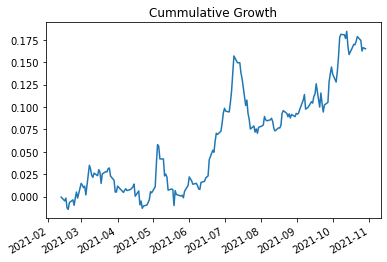

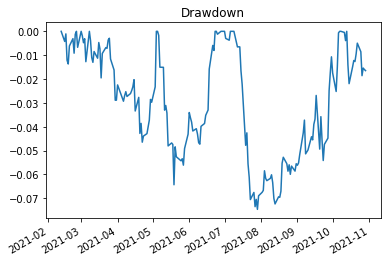

In [408]:
yF_agg = yF.mean(axis=1) 
delta = yF_agg- test_data[lookback:]

weights = np.sign(delta)
#weights[weights < 0] = 0
rets = weights.shift(1)*test_data[lookback:].pct_change()

ret_metrics(rets)

In [382]:
mini_L = pd.read_csv('dax_L_2021-10-31.csv', sep=';',header=1).iloc[:,:-1].rename(columns={'Datum': 'Date', 'Stängn.kurs': 'Long'}).set_index('Date')['Long']
mini_S = pd.read_csv('dax_S_2021-10-31.csv', sep=';',header=1).iloc[:,:-1].rename(columns={'Datum': 'Date', 'Stängn.kurs': 'Short'}).set_index('Date')['Short']

full = pd.DataFrame([])

full = full.append(mini_L)
full = full.append(mini_S)

full = full.T
full.to_csv('./dax_minif_LS_2021-02-01_2021-10_29.csv')